In [910]:
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso 
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt


In [911]:
# read csv file 
df = pd.read_csv("data/insurance.csv")
df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [912]:
# checking for nan values 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


### No missing values in any row, no need to impute/replace missing data ###

In [913]:
# one hot encode categorical columns 
# standardize numerical columns 
X = df.drop(columns = ["charges"])
y = df[["charges"]]

# capture categorical and numerical column names 
categorical_columns = X.select_dtypes(exclude = "number").columns
numerical_columns = X.select_dtypes(include = "number").columns

# create data preprocessor 
preprocessor = ColumnTransformer(
    transformers = [
        ("encoder", OneHotEncoder(), categorical_columns), 
        ("scaler", StandardScaler(), numerical_columns)
    ]
)

# X_processed = new preprocessed dataset 
X_processed = preprocessor.fit_transform(X)
X_processed

array([[ 1.        ,  0.        ,  0.        , ..., -1.43876426,
        -0.45332   , -0.90861367],
       [ 0.        ,  1.        ,  1.        , ..., -1.50996545,
         0.5096211 , -0.07876719],
       [ 0.        ,  1.        ,  1.        , ..., -0.79795355,
         0.38330685,  1.58092576],
       ...,
       [ 1.        ,  0.        ,  1.        , ..., -1.50996545,
         1.0148781 , -0.90861367],
       [ 1.        ,  0.        ,  1.        , ..., -1.29636188,
        -0.79781341, -0.90861367],
       [ 1.        ,  0.        ,  0.        , ...,  1.55168573,
        -0.26138796, -0.90861367]])

### Using PCA to visualize data ###

In [914]:
# 2 component to visualize on 2d graph 
pca = PCA(n_components = 1)
p_components = pca.fit_transform(X_processed)
pca_df = pd.DataFrame(p_components, columns = ["PC1"])
final_pca_df = pd.concat([pca_df, df[["charges"]]], axis = 1)
final_pca_df

,PC1,charges
0,-1.529696,16884.92400
1,-0.549638,1725.55230
2,0.281843,4449.46200
3,-1.470830,21984.47061
4,-0.813172,3866.85520
...,...,...
1333,0.944094,10600.54830
1334,-1.163312,2205.98080
1335,-0.462690,1629.83350
1336,-1.668973,2007.94500


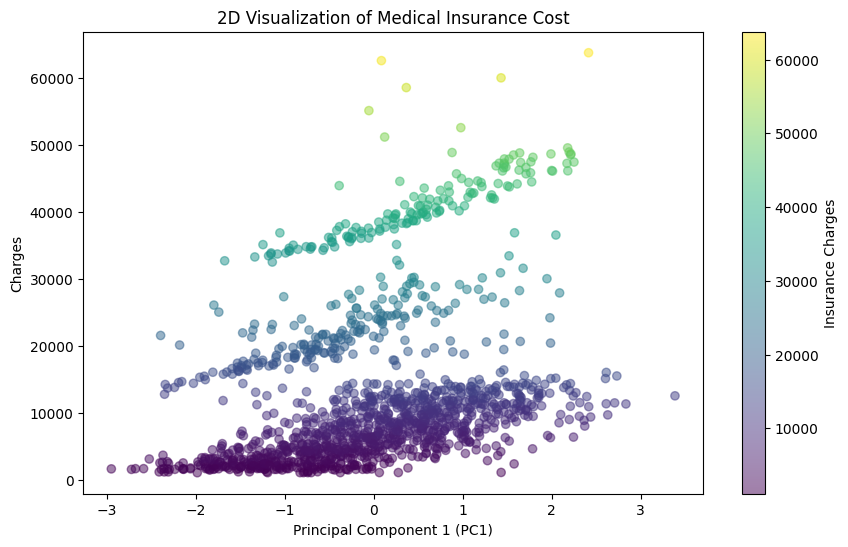

In [915]:
# plotting PCA graph 
plt.figure(figsize=(10, 6))
plt.scatter(final_pca_df["PC1"], y = final_pca_df["charges"], c = final_pca_df["charges"], cmap = "viridis", alpha =0.5)
plt.title("2D Visualization of Medical Insurance Cost")
plt.xlabel("Principal Component 1 (PC1)")
plt.ylabel("Charges")
plt.colorbar(label = "Insurance Charges")
plt.show()

### Observations ###
1. Nothing too meaningful to be concluded from reducing data dimensions

### Model Training ###

In [916]:
# keeping a list of all models used and their loss function scores 
score_list = []

In [917]:
# splitting data 
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size = 0.2, random_state = 42)

In [918]:
# creating pipeline with a linear regression model 
pipe = Pipeline([
    ("linreg", LinearRegression())
])

In [919]:
# parameters to try for linear regression in GridSearchCV 
params = {
    "linreg__fit_intercept": [True, False],
}

model_finder = GridSearchCV(estimator = pipe, param_grid = params, scoring = "r2", cv = 5)
model_finder.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('linreg', LinearRegression())]),
             param_grid={'linreg__fit_intercept': [True, False]}, scoring='r2')

In [920]:
# getting the best model generated from GridSearchCV
best_model = model_finder.best_estimator_

In [921]:
# weights for features generated from best linear regression model 
coefficients = best_model.named_steps["linreg"].coef_
coefficients

array([[-1.46928633e+16, -1.46928633e+16,  6.29644658e+16,
         6.29644658e+16, -4.82716025e+16, -4.82716025e+16,
        -4.82716025e+16, -4.82716025e+16,  3.59125000e+03,
         2.04225000e+03,  4.91468750e+02]])

In [922]:
# use best model from GridSearchCV to predict values 
y_preds = best_model.predict(X_test)
# get r2 score from linear regression model
r2Score = r2_score(y_preds, y_test)
score_list.append({"Linear Regression" : r2Score})
r2Score

0.7084722984462067

In [923]:
score_list 

[{'Linear Regression': 0.7084722984462067}]

### Using Ridge and Lasso Regression # 

In [924]:
# create pipeline using lasso regression 
pipe2 = Pipeline([
    ("lasso", Lasso())
])

In [925]:
# parameters to try for lasso regression in GridSearchCV
lasso_params = {"lasso__alpha" : [0.1, 0.5, 1.0, 5.0, 10.0]}

model_finder_2 = GridSearchCV(estimator = pipe2, param_grid = lasso_params, scoring = "r2", cv = 5)
model_finder_2.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('lasso', Lasso())]),
             param_grid={'lasso__alpha': [0.1, 0.5, 1.0, 5.0, 10.0]},
             scoring='r2')

In [926]:
best_model_2 = model_finder_2.best_estimator_
best_model_2.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('lasso', Lasso(alpha=10.0))])>

In [927]:
# use best model from GridSearchCV to predict values 
y_preds = best_model_2.predict(X_test)
# get r2 score from lasso model 
lasso_score = r2_score(y_preds, y_test)
score_list.append({"Lasso Regression" : lasso_score})
lasso_score

0.7065813350165775

In [928]:
# create a pipeline using ridge regression 
pipe_3 = Pipeline([
    ("ridge", Ridge())
])

In [929]:
# parameters to try for rdige regression in GridSearchCV 
ridge_params = {"ridge__alpha" : [0.1, 0.5, 1.0, 5.0, 10.0]}

model_finder_3 = GridSearchCV(estimator = pipe_3, param_grid = ridge_params, scoring = "r2", cv = 5)
model_finder_3.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('ridge', Ridge())]),
             param_grid={'ridge__alpha': [0.1, 0.5, 1.0, 5.0, 10.0]},
             scoring='r2')

In [930]:
best_model_3 = model_finder_3.best_estimator_ 
best_model_3.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('ridge', Ridge())])>

In [931]:
# use best model from GridSearchCV to predict values 
y_preds = best_model_3.predict(X_test)
# use r2 score from ridge model 
ridge_score = r2_score(y_preds, y_test)
score_list.append({"Ridge Regression" : ridge_score})
ridge_score

0.7071583887320538

In [932]:
# calculating MSE and MAE for models 
y_preds = best_model.predict(X_test)
mse1 = mean_squared_error(y_preds, y_test)
y_preds = best_model_2.predict(X_test)
mse2 = mean_squared_error(y_preds, y_test)
y_preds = best_model_3.predict(X_test)
mse3 = mean_squared_error(y_preds, y_test)
print("MSE VALUES: Linear, Lasso, Ridge")
print(mse1, mse2, mse3)

y_preds = best_model.predict(X_test)
mae1 = mean_absolute_error(y_preds, y_test)
y_preds = best_model_2.predict(X_test)
mae2 = mean_absolute_error(y_preds, y_test)
y_preds = best_model_3.predict(X_test)
mae3 = mean_absolute_error(y_preds, y_test)
print("MAE VALUES: Linear, Lasso, Ridge")
print(mae1, mae2, mae3)

MSE VALUES: Linear, Lasso, Ridge
33720375.68288771 33682605.664767034 33620266.85695226
MAE VALUES: Linear, Lasso, Ridge
4203.566770809906 4189.298110197287 4186.901904691332


### Observations ### 

Best model for r2 score -> LinearRegression()

Best model for MAE and MSE -> Ridge()

### Using polynomial features ###
Checking if adding polynomial features increases model performance

In [933]:
# create a PolynomialFeatures object with a degree of 2
poly = PolynomialFeatures(degree = 2, include_bias = False)
X_poly = poly.fit_transform(X_processed)
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size = 0.2, random_state = 42)

In [934]:
best_model_list = []
pipe = Pipeline([
    ("linreg", LinearRegression())
])

params = {"linreg__fit_intercept" : [True, False]}
poly_model_finder = GridSearchCV(estimator = pipe, param_grid = params, cv = 5, scoring = "r2")
poly_model_finder.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('linreg', LinearRegression())]),
             param_grid={'linreg__fit_intercept': [True, False]}, scoring='r2')

In [935]:
best_poly_model = poly_model_finder.best_estimator_
# append best linear regression model to model list 
best_model_list.append(best_poly_model)
y_preds = best_poly_model.predict(X_test)
poly_score = r2_score(y_preds, y_test)
poly_mse = mean_squared_error(y_preds, y_test)
score_list.append({"Polynomial Linear Regression" : poly_score})
print(poly_score)
print(poly_mse)

0.854580929826676
21208678.15676


Using Polynomial Regression with 2nd degree features gives us a much better r2 score 

In [936]:
lasso_params = {"lasso__alpha" : [0.1, 0.5, 1.0, 5.0, 10.0]}
pipe = Pipeline([
    ("lasso", Lasso(max_iter = 10000))
])

poly_lasso_model = GridSearchCV(estimator = pipe, param_grid = lasso_params, cv = 5, scoring = "r2")
poly_lasso_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('lasso', Lasso(max_iter=10000))]),
             param_grid={'lasso__alpha': [0.1, 0.5, 1.0, 5.0, 10.0]},
             scoring='r2')

In [937]:
best_model = poly_lasso_model.best_estimator_
# append best lasso regression model to model list 
best_model_list.append(best_model)
best_model

Pipeline(steps=[('lasso', Lasso(alpha=10.0, max_iter=10000))])

In [938]:
y_preds = best_model.predict(X_test)
r2 = r2_score(y_preds, y_test)
score_list.append({"Polynomial Lasso Regression" : r2})
r2

0.8500161717858108

In [939]:
ridge_params = {"ridge__alpha" : [0.1, 0.5, 1.0, 5.0, 10.0]}
pipe = Pipeline([
    ("ridge", Ridge(max_iter = 10000))
])

poly_ridge_model = GridSearchCV(estimator = pipe, param_grid = ridge_params, cv = 5, scoring = "r2")
poly_ridge_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('ridge', Ridge(max_iter=10000))]),
             param_grid={'ridge__alpha': [0.1, 0.5, 1.0, 5.0, 10.0]},
             scoring='r2')

In [940]:
best_model = poly_ridge_model.best_estimator_
# append best rdige regression model to model list 
best_model_list.append(best_model)
best_model

Pipeline(steps=[('ridge', Ridge(alpha=5.0, max_iter=10000))])

In [941]:
y_preds = best_model.predict(X_test)
r2 = r2_score(y_preds, y_test)
score_list.append({"Polynomial Rdige Regression" : r2})
r2

0.8482532017689477

In [942]:
for model in best_model_list: 
    print(model)

Pipeline(steps=[('linreg', LinearRegression(fit_intercept=False))])
Pipeline(steps=[('lasso', Lasso(alpha=10.0, max_iter=10000))])
Pipeline(steps=[('ridge', Ridge(alpha=5.0, max_iter=10000))])


### Polynomial Feature r2 scores ###
Best degree = 2 

Scores: LinearRegression() = 0.852, Lasso() = 0.850, Ridge() = 0.848

### Observation ###
When we introduce the use of polynomial features, the r2 scores for the models greatly increases  

### Testing Permutation Importance ###

In [943]:
# creating baseline model 
linreg = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size = 0.2, random_state = 42)

In [944]:
linreg.fit(X_train, y_train)
y_preds = linreg.predict(X_test)
r2 = r2_score (y_test, y_preds)
r2

0.78285555739304

In [945]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(linreg, X_test, y_test, n_repeats = 30, random_state = 42)
print("Permutation Importances:")
for feature, importance in zip(range(X_test.shape[1]), perm_importance.importances_mean):
    print(f"Feature {feature}: {importance}")


Permutation Importances:
Feature 0: 2.087855171055929e+23
Feature 1: 2.0878551710556512e+23
Feature 2: 2.4601824717920314e+27
Feature 3: 2.4601824717921408e+27
Feature 4: 2.294874143488498e+25
Feature 5: 2.6900066087959e+25
Feature 6: 2.936748715952849e+25
Feature 7: 2.462244663727824e+25
Feature 8: 0.15983100420729007
Feature 9: 0.057395545480741744
Feature 10: 0.004796244173057629


### Observation ###
Features 8-10 have little impact on the models performance 

In [946]:
permuted_X_train = X_train[:, :8]
permuted_X_test = X_test[:, :8]
print("New X_train shape after removing non-important features: ", permuted_X_train.shape)
print("New X_test shape after removing non-important features: ", permuted_X_test.shape)

New X_train shape after removing non-important features:  (1070, 8)
New X_test shape after removing non-important features:  (268, 8)


In [947]:
linreg2 = LinearRegression()
linreg2.fit(permuted_X_train, y_train)
y_preds2 = linreg2.predict(permuted_X_test)
r2 = r2_score(y_preds2, y_test)
r2

0.4703932928995559

### Observation ###
Leaving out non-important features from permutation_importance gives a much worse r2 score 

### Permutation Importance on data with Polynomial Features ###

In [948]:
poly = PolynomialFeatures(degree = 2, include_bias = False)
X_poly = poly.fit_transform(X_processed)
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size = 0.2, random_state = 42)

In [949]:
linearRegression = LinearRegression(fit_intercept = False)
linearRegression.fit(X_train, y_train)
y_preds3 = linearRegression.predict(X_test)
r2 = r2_score(y_preds3, y_test)

In [950]:
# using permutation importance 
perm_importance = permutation_importance(linearRegression, X_test, y_test, n_repeats = 30, random_state = 42)
print("Permutation Importances:")
for feature, importance in zip(range(X_test.shape[1]), perm_importance.importances_mean):
    print(f"Feature {feature}: {importance}")

Permutation Importances:
Feature 0: 4.8094383112994085e+22
Feature 1: 2.361696978156485e+24
Feature 2: 2.4009469335054993e+24
Feature 3: 7.260849546529755e+25
Feature 4: 3.4314607026540376e+22
Feature 5: 1.0460878318511092e+24
Feature 6: 1.289920265354057e+24
Feature 7: 1.8745899114341678e+24
Feature 8: 8.744729401299087e+25
Feature 9: 6.8008367102775335e+25
Feature 10: 2.392745667099375e+24
Feature 11: 2.015563083199778e+25
Feature 12: 0.0
Feature 13: 2.815591692606654e+24
Feature 14: 7.59102761204326e+25
Feature 15: 7.375653169817491e+24
Feature 16: 4.809182646542488e+24
Feature 17: 9.67638774408336e+21
Feature 18: 5.893481714171141e+24
Feature 19: 6.103868702136448e+23
Feature 20: 3.760158603055247e+25
Feature 21: 4.5992342787847437e+24
Feature 22: 6.359589712914035e+22
Feature 23: 5.496716220883414e+22
Feature 24: 8.316925082298802e+25
Feature 25: 5.519368131497931e+22
Feature 26: 8.904450211173686e+23
Feature 27: 1.1027209090753735e+25
Feature 28: 2.045304815521955e+23
Feature 29:

In [951]:
importance_scores = perm_importance.importances_mean
# sort scores in descending order 
feature_indices = np.argsort(importance_scores)[::-1]  

feature_size_list = [10, 20, 30, 40 , 50, 55, 60, 65, 70]
for size in feature_size_list:
    important_features = feature_indices[:size]
    perm_X_train = X_train[:, important_features]
    perm_X_test = X_test[:, important_features]
    print("New X_train shape after removing non-important features: ", perm_X_train.shape)
    print("New X_test shape after removing non-important features: ", perm_X_test.shape)
    linearRegression.fit(perm_X_train, y_train)
    y_preds4 = linearRegression.predict(perm_X_test)
    r2 = r2_score(y_preds4, y_test)
    if size == 30:
        score_list.append({"Polynomial Linear Regression with PI" : r2})
    print(r2)


New X_train shape after removing non-important features:  (1070, 10)
New X_test shape after removing non-important features:  (268, 10)
0.573284211980102
New X_train shape after removing non-important features:  (1070, 20)
New X_test shape after removing non-important features:  (268, 20)
0.7140269146974767
New X_train shape after removing non-important features:  (1070, 30)
New X_test shape after removing non-important features:  (268, 30)
0.8466852778486813
New X_train shape after removing non-important features:  (1070, 40)
New X_test shape after removing non-important features:  (268, 40)
0.8454936827412453
New X_train shape after removing non-important features:  (1070, 50)
New X_test shape after removing non-important features:  (268, 50)
0.8495514360722214
New X_train shape after removing non-important features:  (1070, 55)
New X_test shape after removing non-important features:  (268, 55)
0.8484467515188462
New X_train shape after removing non-important features:  (1070, 60)
Ne

### Observations ### 
Using varying degrees of features from permutation importance metrics gives almost identical performance to using all 77 features generated from the dataset with a polynomial degree of 2 

Once we jump from 20 to 30+ features the increase in performance from then until all 77 features is very minimal 

### Using Sequential Feature Selector ###

In [952]:
from sklearn.feature_selection import SequentialFeatureSelector
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size = 0.2, random_state = 42)
linregmodel = LinearRegression(fit_intercept = False)
selector = SequentialFeatureSelector(linregmodel, n_features_to_select = 4, cv = 5)
selector.fit(X_train, y_train)

# Transform the training and test data to include only the selected features
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Train a linear regression model on the selected features
linregmodel.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred = linregmodel.predict(X_test_selected)

# Evaluate the model
r2 = r2_score(y_pred, y_test)
r2

0.7016710022637013

### Observations ###
1. Reducing the number of features to 4 from 11 after putting the data in the preprocessor yields a similar r2 score to when all 11 features are used (~70%)
2. Anything less than 4 features gives about a 3% drop in accuracy from 70% 

In [953]:
poly2 = PolynomialFeatures(degree = 2, include_bias = False)
X_poly = poly2.fit_transform(selector.transform(X_processed))
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size = 0.2, random_state = 42)

In [954]:
poly_linreg = LinearRegression(fit_intercept = False)
poly_linreg.fit(X_train, y_train)
y_preds5 = poly_linreg.predict(X_test)
r2 = r2_score(y_preds5, y_test)
score_list.append({"Polynomial Linear Regression with SFS" : r2})
r2

0.8441216512224449

### Observations ###
Using permutation importance and sequential feature selection on the Linear Regression model gave similar results to using all of the given features with added polynomial features 

In [955]:
score_list

[{'Linear Regression': 0.7084722984462067},
 {'Lasso Regression': 0.7065813350165775},
 {'Ridge Regression': 0.7071583887320538},
 {'Polynomial Linear Regression': 0.854580929826676},
 {'Polynomial Lasso Regression': 0.8500161717858108},
 {'Polynomial Rdige Regression': 0.8482532017689477},
 {'Polynomial Linear Regression with PI': 0.8466852778486813},
 {'Polynomial Linear Regression with SFS': 0.8441216512224449}]

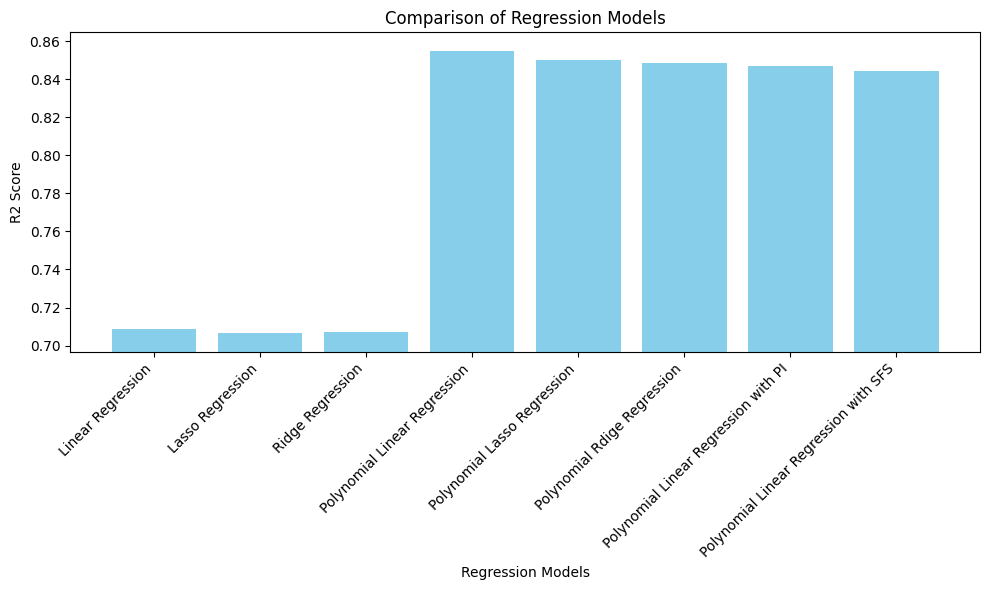

In [956]:
# Get model names and values 
model_names = [list(score.keys())[0] for score in score_list]
model_values = [list(score.values())[0] for score in score_list]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(model_names, model_values, color = "skyblue")
plt.xlabel("Regression Models")
plt.ylabel("R2 Score")
plt.title("Comparison of Regression Models")
plt.xticks(rotation = 45, ha = "right")
plt.ylim(min(model_values) - 0.01, max(model_values) + 0.01)
plt.tight_layout()

# Show the plot
plt.show()

In [957]:
print(model_names)
print(model_values)

['Linear Regression', 'Lasso Regression', 'Ridge Regression', 'Polynomial Linear Regression', 'Polynomial Lasso Regression', 'Polynomial Rdige Regression', 'Polynomial Linear Regression with PI', 'Polynomial Linear Regression with SFS']
[0.7084722984462067, 0.7065813350165775, 0.7071583887320538, 0.854580929826676, 0.8500161717858108, 0.8482532017689477, 0.8466852778486813, 0.8441216512224449]


### Conclusion ###
Polynomial Linear Regression is the best model and it has the highest accuracy out of all of the models tested 

### Testing preprocessing data after splitting ### 

In [958]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [959]:
pipe = Pipeline([
    ("preprocessor", preprocessor), 
    ("poly", PolynomialFeatures(degree = 2, include_bias = False)), 
    ("linreg", LinearRegression(fit_intercept = False))
])

pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('encoder', OneHotEncoder(),
                                                  Index(['sex', 'smoker', 'region'], dtype='object')),
                                                 ('scaler', StandardScaler(),
                                                  Index(['age', 'bmi', 'children'], dtype='object'))])),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('linreg', LinearRegression(fit_intercept=False))])

In [960]:
pipe.fit(X_train, y_train)
y_preds = pipe.predict(X_test)
r2 = r2_score(y_preds, y_test)
mse = mean_squared_error(y_preds, y_test)
print(r2, mse)

0.855412312729924 21045739.791766383


Slightly better performance when scaling data AFTER splitting into train and test sets 

### Neural Network Model ###

In [961]:
%pip install tensorflow

In [962]:
import tensorflow as tf

In [963]:
# one hot encode categorical columns 
# standardize numerical columns 
X = df.drop(columns = ["charges"])
y = df[["charges"]]

categorical_columns = X.select_dtypes(exclude = "number").columns
numerical_columns = X.select_dtypes(include = "number").columns

preprocessor = ColumnTransformer(
    transformers = [
        ("encoder", OneHotEncoder(), categorical_columns), 
        ("scaler", StandardScaler(), numerical_columns)
    ]
)

nn_pipe = Pipeline([
    ("preprocessor", preprocessor), 
    ("poly", PolynomialFeatures(degree = 2, include_bias = False)), 
    #("linreg", LinearRegression(fit_intercept = False))
])
print(categorical_columns)
print(numerical_columns)

Index(['sex', 'smoker', 'region'], dtype='object')
Index(['age', 'bmi', 'children'], dtype='object')


In [964]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# fit and transform training data with preprocessor and polynomial features 
# transform test data once training data is transformed 
X_train_preprocessed = nn_pipe.fit_transform(X_train)
X_test_preprocessed = nn_pipe.transform(X_test)

# Build and train Sequential Neural Network 
# Starts with 128 neurons, decreases by half in each layer until 32, then the output layer is reached 
model = Sequential([
    Dense(units = 128, activation = "relu", input_dim = X_train_preprocessed.shape[1]),
    Dense(units = 64, activation = "relu"),
    Dense(units = 32, activation = "relu"),
    Dense(units = 1, activation = "linear")  # output layer 
])

# adam optimizer uses smoothening and an adaptive learning rate 
model.compile(optimizer = "adam", loss = "mean_squared_error")

# forward and backward propogation done 100 times (epochs)
model.fit(X_train_preprocessed, y_train, epochs = 100)

# Evaluate the model on the test set
loss = model.evaluate(X_test_preprocessed, y_test)
print(f'Mean Squared Error on Test Set: {loss}')

Epoch 1/100
34/34 [==============================] - 2s 3ms/step - loss: 322315328.0000
Epoch 2/100
34/34 [==============================] - 0s 2ms/step - loss: 320347040.0000
Epoch 3/100
34/34 [==============================] - 0s 2ms/step - loss: 305749376.0000
Epoch 4/100
34/34 [==============================] - 0s 2ms/step - loss: 253353840.0000
Epoch 5/100
34/34 [==============================] - 0s 2ms/step - loss: 168190448.0000
Epoch 6/100
34/34 [==============================] - 0s 2ms/step - loss: 124977360.0000
Epoch 7/100
34/34 [==============================] - 0s 2ms/step - loss: 107394728.0000
Epoch 8/100
34/34 [==============================] - 0s 2ms/step - loss: 91476240.0000
Epoch 9/100
34/34 [==============================] - 0s 2ms/step - loss: 76744264.0000
Epoch 10/100
34/34 [==============================] - 0s 2ms/step - loss: 62214220.0000
Epoch 11/100
34/34 [==============================] - 0s 2ms/step - loss: 49185744.0000
Epoch 12/100
34/34 [==============

Neural Network model with 100 epochs and 4 layers has similar performance to regular linear regression model using polynomial features (degree 2) 

In [965]:
# change number format 
poly_mse2 = "{:.2f}".format(poly_mse)
compare = {"Linear Model" : poly_mse2, "Neural Network" : loss}
cdf = pd.DataFrame(compare, index = [0])
print(poly_mse2, loss)
cdf

21208678.16 20052286.0


,Linear Model,Neural Network
0,21208678.16,20052286.0


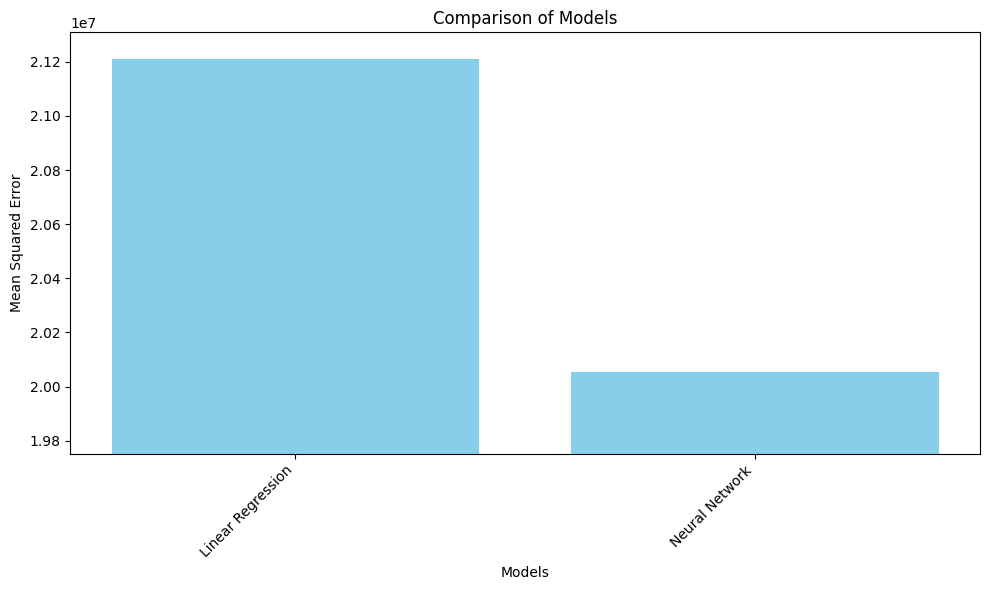

In [966]:
# Extract model names and their corresponding values
model_names2 = ["Linear Regression", "Neural Network"]
model_values2 = [int(float(poly_mse2)), int(float(loss))]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(model_names2, model_values2, color="skyblue")
plt.xlabel("Models")
plt.ylabel("Mean Squared Error")
plt.title("Comparison of Models")
plt.xticks(rotation=45, ha="right")
plt.ylim(min(model_values2) - 300000, max(model_values2) + 100000)
plt.tight_layout()
plt.show()


### Final Observations ###
1. Neural Network model performs slightly better than Linear Regression Model 
2. Permutation Importance and Sequential Feature Selection did not help much with improving model performance 
3. Linear Regression performed the best in all iterations (polynomial features, SFS, PI) in terms of R2 score
4. Ridge and Lasso Regression performed the best in terms of MSE and MAE 

Overall, I would say that the neural network is the best produced model, as it has the lowest MSE and performs slightly better than the Linear Regression model once feature engineering has been used with polynomial features (best degree is 2). 

If I were to continue to gather data and improve the model, I would use the neural network model. 